In [1]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

import abc
from abc import ABC, abstractmethod

from utils import eq_covariance,                 \
                  sample_datasets_from_gps,      \
                  gp_post_pred,                  \
                  np_plot_sample_and_predictions

# Sample and plot a few datapoints

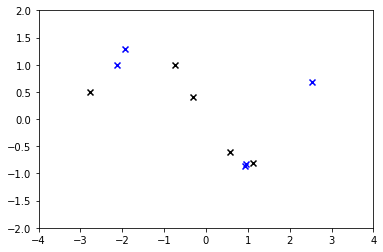

In [2]:
train_data, test_data = sample_datasets_from_gps(low=-3.,
                                                 high=3.,
                                                 batch_size=1,
                                                 num_train=5,
                                                 num_test=5,
                                                 scale=1e0,
                                                 cov_coeff=1e0,
                                                 noise_coeff=1e-1,
                                                 as_tensor=True)
                                    
plt.scatter(train_data[0][0], train_data[1][0], marker='x', color='black')
plt.scatter(test_data[0][0], test_data[1][0], marker='x', color='blue')

plt.xlim([-4, 4])
plt.ylim([-2, 2])
plt.show()

# NP definition

In [127]:
# class NeuralProcess(nn.Module):
    
#     def __init__(self,
#                  cond_lik,
#                  encoder,
#                  prior):
        
#         super().__init__()
        
#         self.cond_lik = cond_lik
#         self.encoder = encoder
#         self.prior = prior
        
#         self.normal = torch.distributions.Normal
        
        
#     def forward(self,
#                 context_inputs,
#                 context_outputs,
#                 target_inputs):
        
#         context_inputs = context_inputs.unsqueeze(dim=-1)
#         context_outputs = context_outputs.unsqueeze(dim=-1)
#         target_inputs = target_inputs.unsqueeze(dim=-1)
        
#         context = torch.cat([context_inputs, context_outputs], dim=-1)
        
#         theta_post_params = self.encoder(context)
#         theta_post_params = torch.mean(theta_post_params, dim=1)[:, None, :]
#         theta_post_params = torch.reshape(theta_post_params,
#                                           theta_post_params.shape[:-1] + (-1, 2))
        
#         theta_mean = theta_post_params[:, :, :, 0]
#         theta_stdev = torch.exp(theta_post_params[:, :, :, 1])
        
#         theta_post = torch.distributions.Normal(theta_mean, theta_stdev)
        
#         theta_sample = theta_post.rsample()
        
#         kl_divergence = torch.distributions.kl_divergence(theta_post, prior)
        
#         theta_sample = theta_sample.repeat(1, target_inputs.shape[1], 1)
#         tensor = torch.cat([target_inputs, theta_sample], dim=-1)
        
#         tensor = self.cond_lik(tensor)
#         tensor = torch.reshape(tensor, tensor.shape[:2] + (-1, 2))
        
#         mean, log_stdev = tensor[:, :, :, 0], tensor[:, :, :, 1]
        
#         return mean, log_stdev, kl_divergence, theta_sample
    
    
#     def _loss(self,
#               context_inputs,
#               context_outputs,
#               target_inputs,
#               target_outputs):
        
#         target_outputs = target_outputs.unsqueeze(dim=-1)
        
#         mean, log_stdev, kl_divergence, _ = self.forward(context_inputs,
#                                                          context_outputs,
#                                                          target_inputs)
        
#         stdev = torch.exp(log_stdev)
        
#         cond_dist = self.normal(loc=mean, scale=stdev)
        
#         log_prob = cond_dist.log_prob(target_outputs)
        
#         log_prob = torch.mean(log_prob, dim=0)
#         log_prob = torch.sum(log_prob)
        
#         kl_divergence = torch.sum(kl_divergence, dim=[1, 2])
#         kl_divergence = torch.mean(kl_divergence)
        
#         elbo = log_prob - 1e-1 * kl_divergence
        
#         return - elbo
    
    
#     def loss(self,
#              inputs,
#              outputs,
#              num_samples):
        
#         loss = 0
        
#         for i in range(num_samples):
            
#             N = np.random.choice(np.arange(1, inputs.shape[1]))
            
#             context_inputs = inputs[:, :N]
#             context_outputs = outputs[:, :N]
#             target_inputs = inputs[:, N:]
#             target_outputs = outputs[:, N:]
            
#             loss = loss + self._loss(context_inputs,
#                                      context_outputs,
#                                      target_inputs,
#                                      target_outputs)
        
#         loss = loss / num_samples
        
#         return loss

In [128]:
class FeedforwardNetwork(nn.Module):
    
    def __init__(self,
                 input_dim,
                 output_dim,
                 nums_hidden,
                 nonlinearity):
        
        super().__init__()
        
        # Set sizes for linear layers
        sizes = [input_dim] + nums_hidden + [output_dim]
        sizes = [(s1, s2) for s1, s2 in zip(sizes[:-1], sizes[1:])]
        
        # Create linear layers
        self.linear = [nn.Linear(s1, s2, bias=True) for s1, s2 in sizes]
        self.linear = nn.ModuleList(self.linear)
        
        # Nonlinearity to use after each linear layer except the last
        self.nonlinearity = getattr(nn, nonlinearity)()
        
    
    def forward(self, tensor):
        
        # Apply each linear layer (except last) and nonlinearity
        for linear in self.linear[:-1]:
            
            tensor = linear(tensor)
            tensor = self.nonlinearity(tensor)
            
        # Apply last linear layer
        tensor = self.linear[-1](tensor)
        
        return tensor

In [129]:
class ConcatenationEncoder(nn.Module):
    
    def __init__(self,
                 transformation,
                 stochastic_layer):
        
        super().__init__()
        
        self.transformation = transformation
        self.stochastic_layer = stochastic_layer
    
    def forward(self,
                context_inputs,
                context_outputs):
        
        # Concatenate context inputs and outputs
        tensor = torch.cat([context_inputs, context_outputs], dim=-1)
        
        # Pass context tensor through transformation
        tensor = self.transformation(tensor)
        
        # Get approximate posterior parameters and distribution
        approx_post_params = torch.mean(tensor, dim=1)[:, None, :]
        approx_post = self.stochastic_layer(approx_post_params)
        
        return approx_post
        
    
class RepeatDecoder(nn.Module, ABC):
    
    def __init__(self,
                 transformation,
                 stochastic_layer):
        
        super().__init__()
        
        self.transformation = transformation
        self.stochastic_layer = stochastic_layer
        
    
    def forward(self,
                context,
                target_inputs):
        
        # Repeat context tensor for each datapoint
        context = context[:, :, None, :]
        context = context.repeat(1, 1, target_inputs.shape[1], 1)
        
        target_inputs = target_inputs[None, :, :, :]
        target_inputs = target_inputs.repeat(context.shape[0], 1, 1, 1)
        
        # Concatenate inputs and context
        tensor = torch.cat([target_inputs, context], dim=-1)
        
        # Pass context tensor through transformation
        tensor = self.transformation(tensor)
        
        # Get approximate posterior parameters and distribution
        cond_lik = self.stochastic_layer(tensor)
        
        return cond_lik

In [163]:
class StochasticLayer(ABC, nn.Module):
    
    def __init__(self, distribution):
        
        super().__init__()
        
        # Set the distribution to use
        self.distribution_type = getattr(torch.distributions,
                                         distribution)
        
    @abstractmethod
    def reparametrise(self, tensor):
        pass
    
    def __call__(self, tensor):
        
        # Reparametrise raw tensor to get distribution parameters
        distribution_params = self.reparametrise(tensor)
        
        # Instantiate distribution using parameters
        distribution = self.distribution_type(**distribution_params)
        
        return distribution
    
    
class NormalStochasticLayer(StochasticLayer):
    
    def __init__(self, single_noise_param, reparam_func):
        
        super().__init__(distribution='Normal')
        
        if reparam_func == 'sigmoid':
            self.reparam_func = torch.nn.Sigmoid()
            
        elif reparam_func == 'softplus':
            self.reparam_func = torch.nn.Softplus()
        
        self.single_noise_param = single_noise_param
        
        if single_noise_param:
            self.unc_scale = nn.Parameter(torch.tensor(0.))
            
        self.num_params = 1 if single_noise_param else 2
            
        
    def reparametrise(self, tensor):
        
        tensor = torch.reshape(tensor, tensor.shape[:-2] + (-1, self.num_params))
        
        loc = tensor[..., 0]
        unc_scale = self.unc_scale if self.single_noise_param else tensor[..., 1]
        
        param_dict = {'loc'   : loc,
                      'scale' : self.reparam_func(unc_scale) + 1e-3}
        
        return param_dict

In [164]:
class NeuralProcess(nn.Module):
    
    def __init__(self,
                 encoder,
                 decoder,
                 prior):
        
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        self.prior = prior
    
    
    def forward(self,
                context_inputs,
                context_outputs,
                target_inputs,
                sample_output=False):
        
        # Approximate posterior of (sub-sampled) context points
        context_approx_post = self.encoder(context_inputs,
                                           context_outputs)
            
        # Sample context from approximate posterior
        context_sample = context_approx_post.rsample(sample_shape=(1,))
            
        # Pass target inputs and context sample through decoder
        cond_lik_dist = self.decoder(context_sample,
                                     target_inputs)
        
        # Sample output from conditional likelihood distribution
        if sample_output:
            return cond_lik_dist.rsample()[0]
        
        else:
            return cond_lik_dist.mean[0], cond_lik_dist.stddev[0]
    
    
    def loss(self,
             inputs,
             outputs,
             num_mc_samples,
             num_subsamples):
        
        total_log_lik = 0.
        total_kl = 0.
        total_elbo = 0.
        
        # Approximate posterior of all observed datapoints
        full_approx_post = self.encoder(inputs, outputs)
        
        for i in range(num_subsamples):
            
            # Number of context points
            N = np.random.choice(np.arange(1, outputs.shape[1] - 1))
            
            # Split context and target inputs/outputs
            context_inputs = inputs[:, :N]
            context_outputs = outputs[:, :N]
            target_inputs = inputs[:, N:]
            target_outputs = outputs[:, N:]
            
            # Approximate posterior of (sub-sampled) context points
            context_approx_post = self.encoder(context_inputs,
                                               context_outputs)

            # KL of full approx. posterior to context approx. posterior
            kl_divergence = torch.distributions.kl_divergence(full_approx_post,
                                                              context_approx_post)
            kl_divergence = torch.sum(kl_divergence, dim=-1)
            kl_divergence = torch.mean(kl_divergence)
                
            # Sample context from approximate posterior
            context_sample = full_approx_post.rsample(sample_shape=(num_mc_samples,))

            # Pass target inputs and context sample through decoder
            cond_lik_dist = self.decoder(context_sample, inputs)

            # Compute log likeelihood of target outputs
            log_lik = cond_lik_dist.log_prob(outputs[None, ..., 0])
            
            # Mean over number of MC samples and datasets, sum over datapoints
            log_lik = torch.mean(log_lik, dim=[0, 1])
            log_lik = torch.sum(log_lik)
                
            total_log_lik = total_log_lik + log_lik
            total_kl = total_kl + kl_divergence
            total_elbo = total_elbo + torch.mean(log_lik) - torch.mean(kl_divergence)
        
        # Compute ELBO for current nuumber of subsamples
        total_log_lik = total_log_lik / num_subsamples
        total_kl = total_kl / num_subsamples
        total_elbo = total_elbo / num_subsamples
        
        return - total_elbo, total_log_lik, total_kl

In [170]:
# Encoder modules
transformation = FeedforwardNetwork(input_dim=2,
                                    output_dim=256,
                                    nums_hidden=[128, 128],
                                    nonlinearity='ReLU')

stochastic_layer = NormalStochasticLayer(single_noise_param=False,
                                         reparam_func='sigmoid')

encoder = ConcatenationEncoder(transformation,
                               stochastic_layer)

# Decoder modules
transformation = FeedforwardNetwork(input_dim=129,
                                    output_dim=1,
                                    nums_hidden=[128, 128, 128, 128],
                                    nonlinearity='ReLU')

stochastic_layer = NormalStochasticLayer(single_noise_param=True,
                                         reparam_func='softplus')

decoder = RepeatDecoder(transformation,
                        stochastic_layer)


# Neural Process
prior = torch.distributions.Normal

neural_process = NeuralProcess(encoder,
                               decoder,
                               prior)

# Training

In [173]:
# ! rm -rf ./model_checkpoints
# ! mkdir ./model_checkpoints

-32.89405822753906, -32.14847946166992, 0.7455791234970093


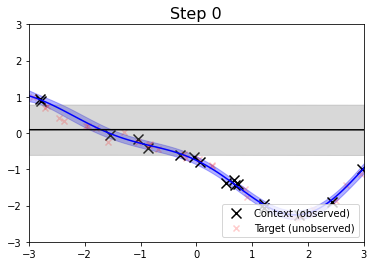

-21.249242782592773, -21.19461441040039, 0.05462764576077461


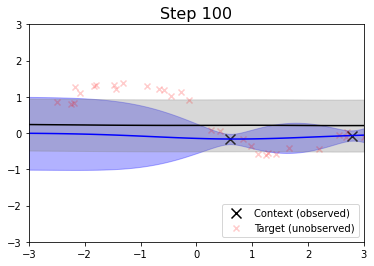

-23.69838523864746, -19.220245361328125, 4.478139877319336


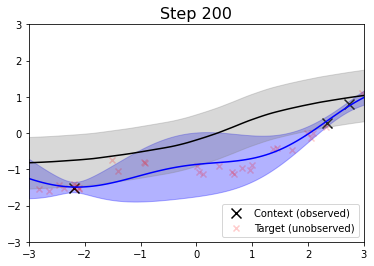

-21.38003921508789, -17.456745147705078, 3.923295021057129


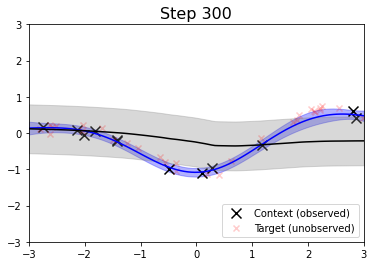

-16.134502410888672, -15.710562705993652, 0.42394039034843445


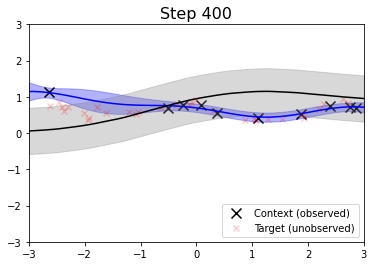

-17.350299835205078, -16.66336441040039, 0.6869348287582397


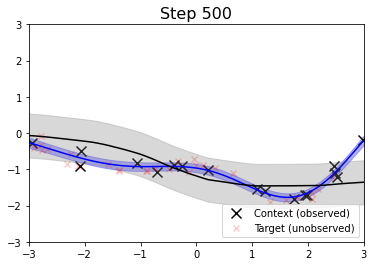

-17.466047286987305, -17.23529052734375, 0.23075585067272186


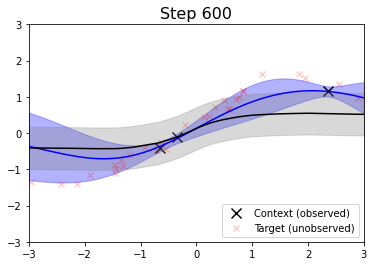

-24.882064819335938, -15.784887313842773, 9.097177505493164


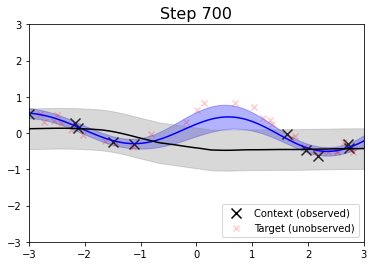

-18.896984100341797, -14.076261520385742, 4.820721626281738


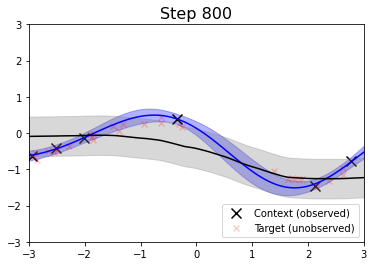

-14.019756317138672, -13.820917129516602, 0.19883891940116882


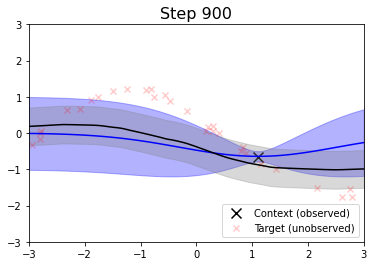

-16.94866180419922, -15.24374771118164, 1.7049144506454468


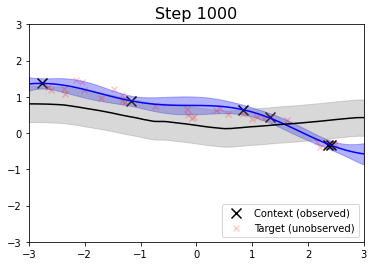

-13.99679946899414, -12.36646556854248, 1.630333662033081


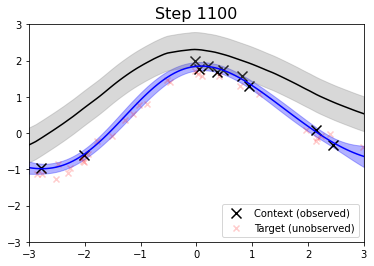

-15.397409439086914, -14.058551788330078, 1.3388575315475464


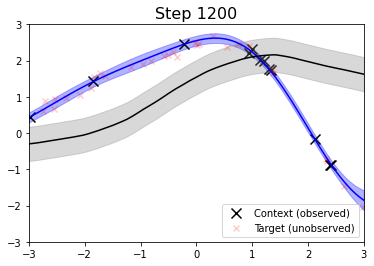

-14.250304222106934, -12.762846946716309, 1.4874573945999146


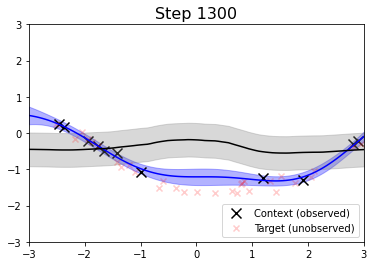

-18.728857040405273, -13.071081161499023, 5.65777587890625


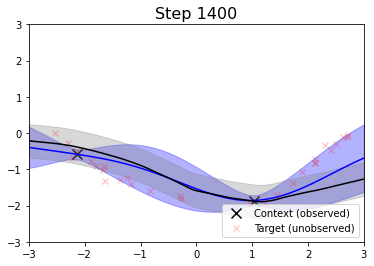

-14.829022407531738, -10.766290664672852, 4.062731742858887


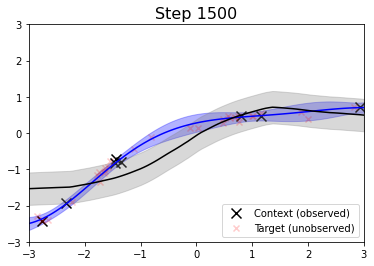

-43.65081787109375, -11.412083625793457, 32.23873519897461


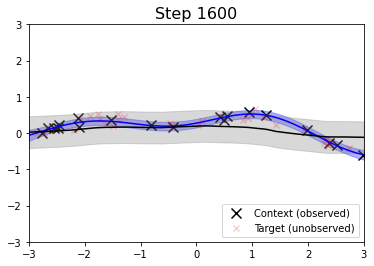

-13.933030128479004, -10.059348106384277, 3.8736820220947266


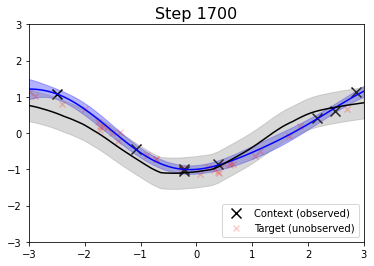

-11.150348663330078, -10.962913513183594, 0.18743528425693512


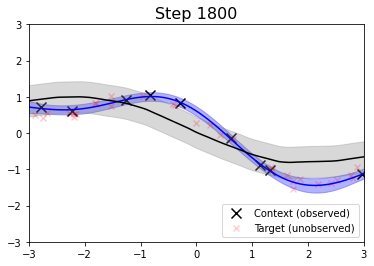

-11.708734512329102, -11.401277542114258, 0.3074566721916199


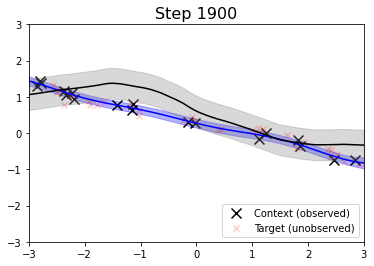

-13.765209197998047, -11.638519287109375, 2.126690149307251


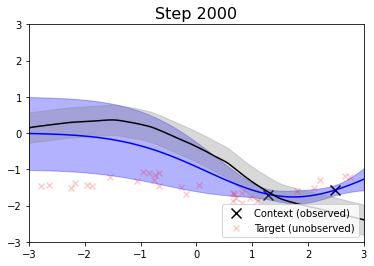

-11.518101692199707, -11.365608215332031, 0.15249335765838623


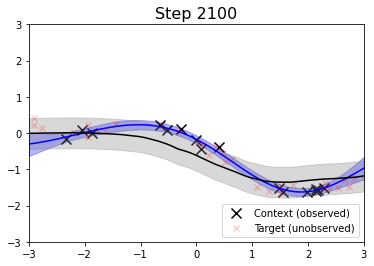

-12.690805435180664, -10.94611930847168, 1.7446856498718262


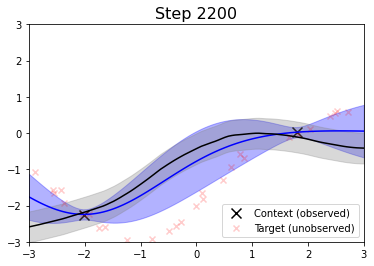

-10.12020492553711, -9.838223457336426, 0.28198182582855225


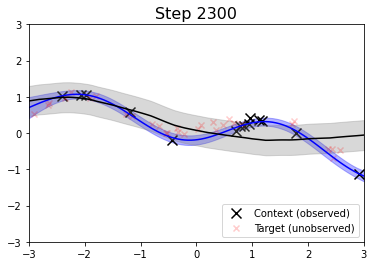

-14.739791870117188, -12.672504425048828, 2.0672876834869385


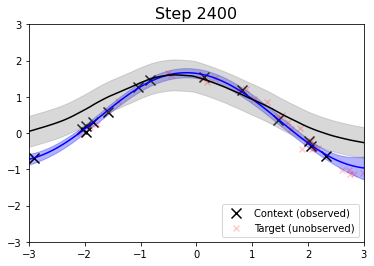

-11.967144012451172, -11.81554126739502, 0.15160275995731354


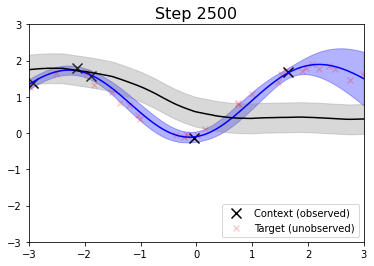

-10.447114944458008, -9.360349655151367, 1.0867655277252197


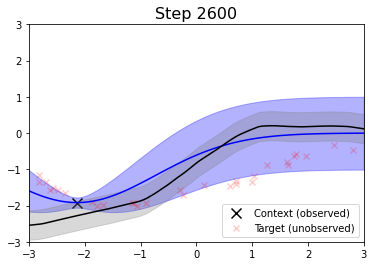

-15.837270736694336, -9.750722885131836, 6.086547374725342


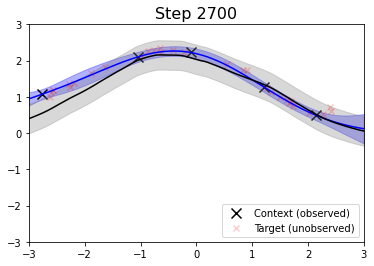

-12.081976890563965, -11.452747344970703, 0.6292294263839722


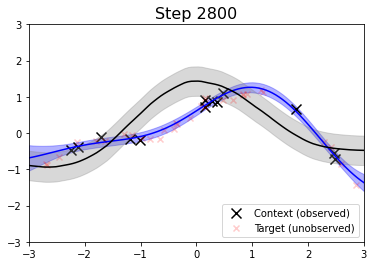

-17.34551429748535, -11.181221008300781, 6.1642937660217285


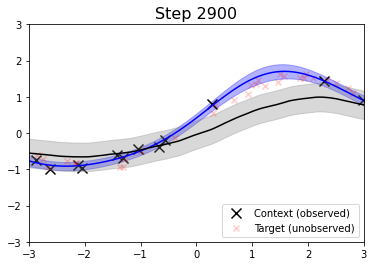

-15.014850616455078, -11.131799697875977, 3.8830511569976807


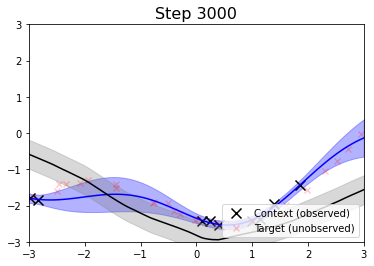

-9.377642631530762, -8.76983642578125, 0.6078062653541565


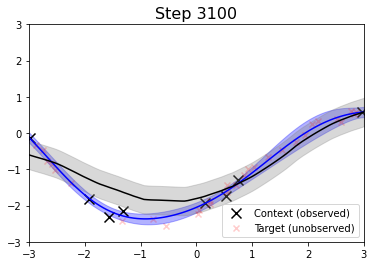

-17.646270751953125, -9.566027641296387, 8.080244064331055


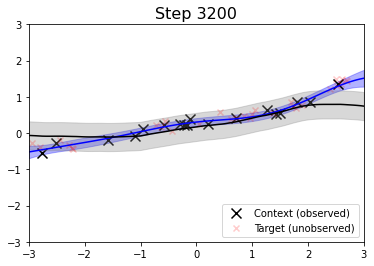

-12.631945610046387, -10.126458168029785, 2.5054874420166016


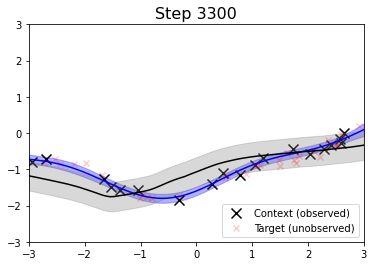

-16.482820510864258, -10.519100189208984, 5.963720798492432


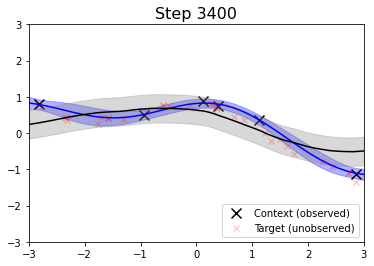

-11.286420822143555, -10.361152648925781, 0.9252683520317078


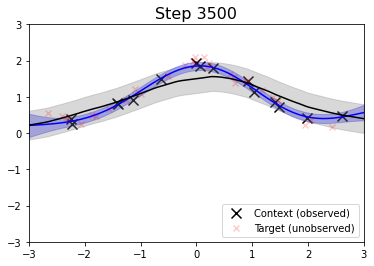

-11.346688270568848, -10.274276733398438, 1.0724117755889893


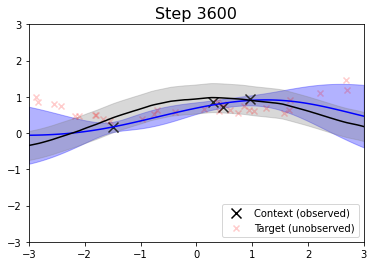

-11.073819160461426, -9.912700653076172, 1.1611186265945435


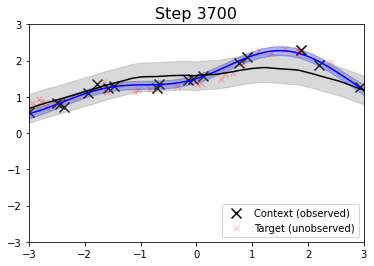

-21.44290542602539, -10.677825927734375, 10.765079498291016


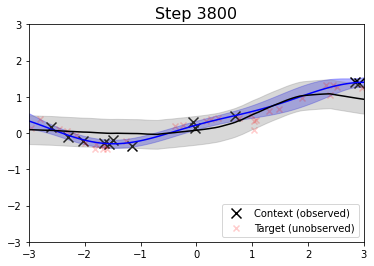

-13.734189987182617, -11.670332908630371, 2.063857316970825


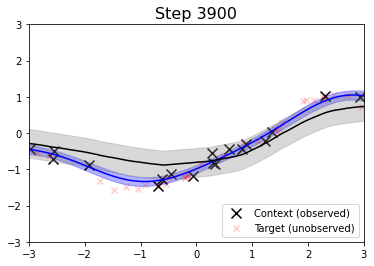

-22.00049591064453, -10.047872543334961, 11.952622413635254


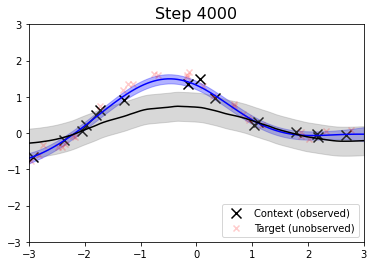

-9.856977462768555, -9.693794250488281, 0.1631830781698227


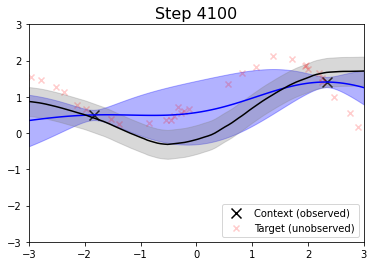

-9.114977836608887, -8.96562385559082, 0.14935417473316193


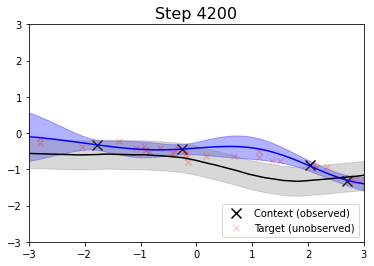

-10.162284851074219, -8.53921127319336, 1.623073935508728


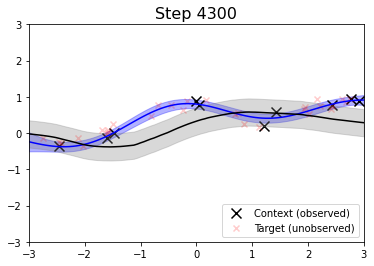

-10.22416877746582, -9.94993782043457, 0.2742307782173157


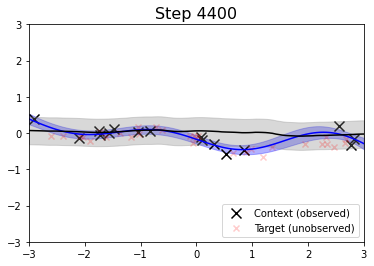

-10.338357925415039, -8.91252326965332, 1.4258347749710083


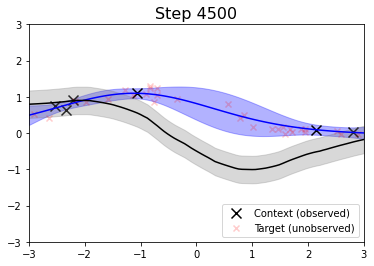

-18.505146026611328, -9.049718856811523, 9.455428123474121


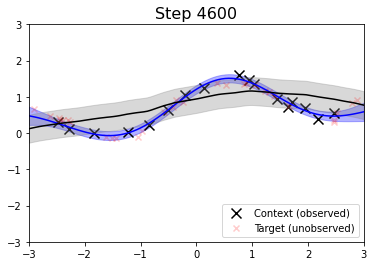

-11.909351348876953, -10.66338062286377, 1.2459708452224731


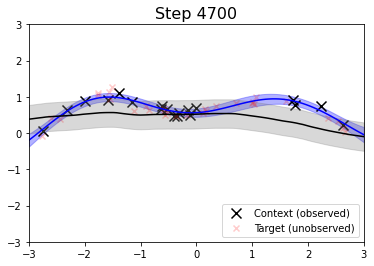

-9.796727180480957, -8.767437934875488, 1.0292894840240479


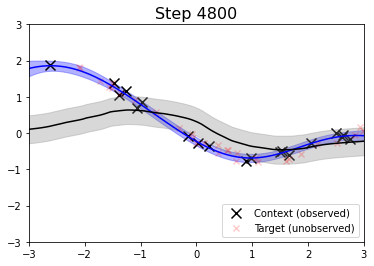

-16.475223541259766, -9.583269119262695, 6.891953945159912


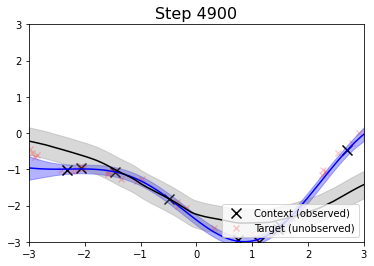

-11.045320510864258, -9.75340461730957, 1.2919155359268188


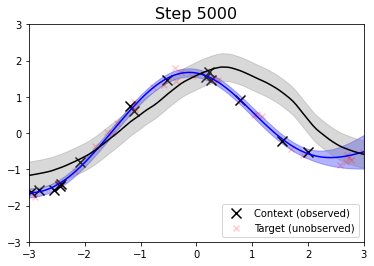

-18.20221710205078, -9.194445610046387, 9.007771492004395


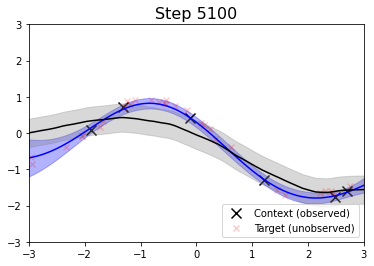

-8.057769775390625, -7.842019557952881, 0.21575041115283966


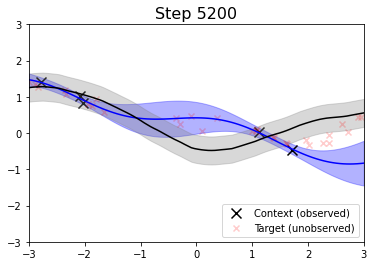

-13.763882637023926, -8.193687438964844, 5.570195198059082


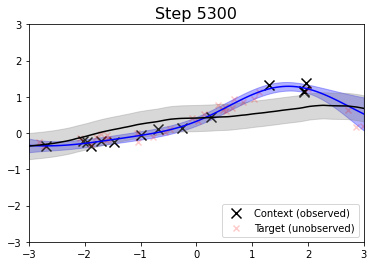

-9.528923034667969, -8.527114868164062, 1.0018081665039062


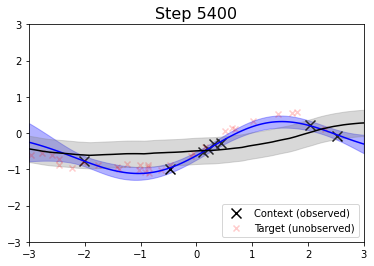

-12.140752792358398, -11.648082733154297, 0.4926697909832001


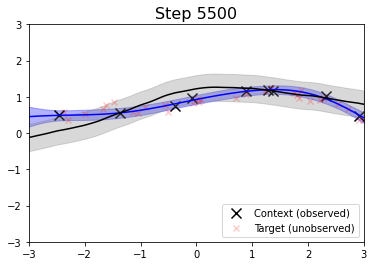

-23.822978973388672, -9.106525421142578, 14.716452598571777


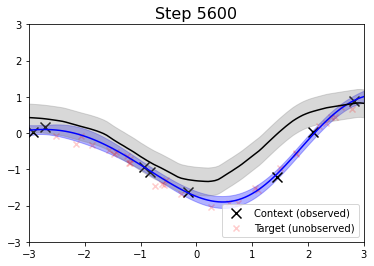

-14.491083145141602, -7.520139694213867, 6.970943450927734


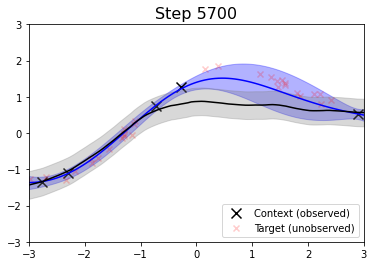

-10.550024032592773, -8.49404239654541, 2.055981159210205


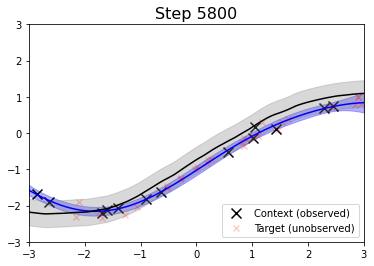

-10.866026878356934, -8.692373275756836, 2.1736538410186768


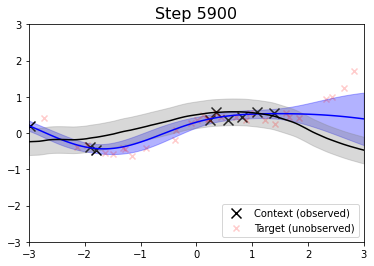

-37.43193054199219, -8.734664916992188, 28.697265625


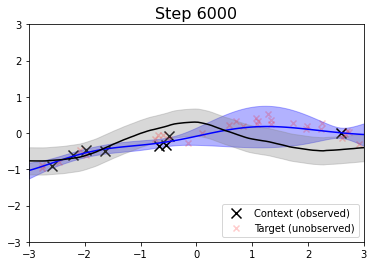

-9.00646686553955, -6.848140239715576, 2.1583266258239746


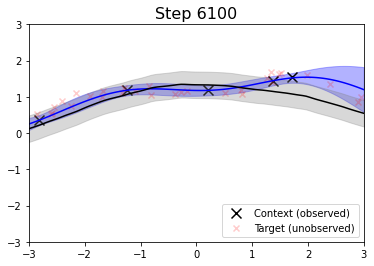

-15.284618377685547, -8.513903617858887, 6.770714282989502


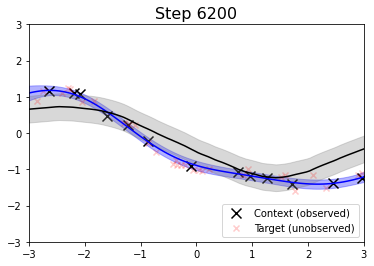

-6.94016695022583, -6.629932880401611, 0.310234010219574


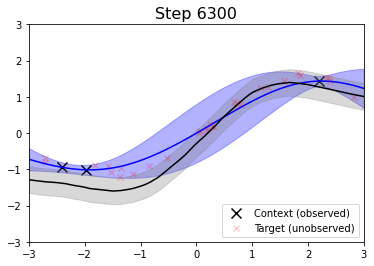

-10.719453811645508, -8.511849403381348, 2.207604169845581


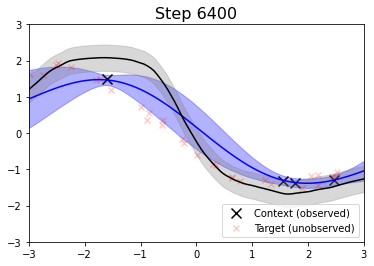

-9.450008392333984, -7.877231597900391, 1.5727767944335938


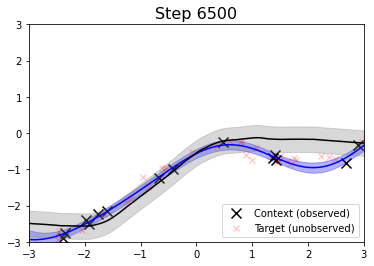

-9.100458145141602, -8.608036041259766, 0.4924222528934479


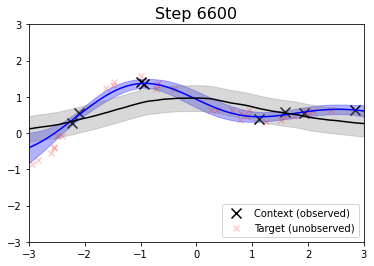

-9.73342514038086, -7.933365821838379, 1.800059199333191


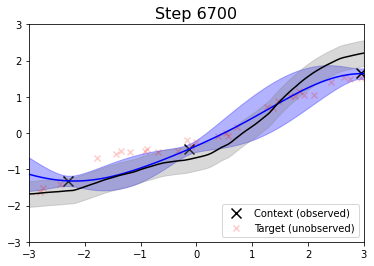

-8.729998588562012, -7.829191207885742, 0.9008074402809143


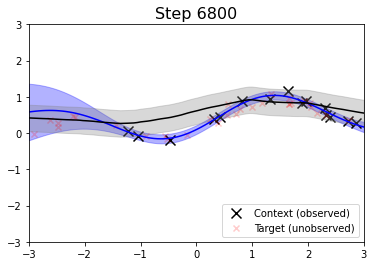

-23.429115295410156, -7.594241142272949, 15.83487319946289


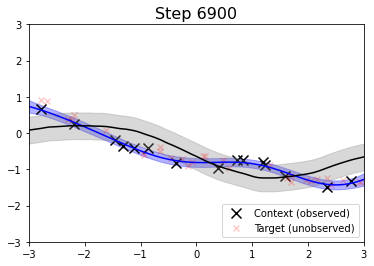

-15.090959548950195, -8.871234893798828, 6.219725131988525


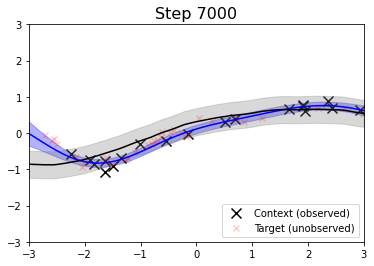

-11.961324691772461, -9.843830108642578, 2.117495059967041


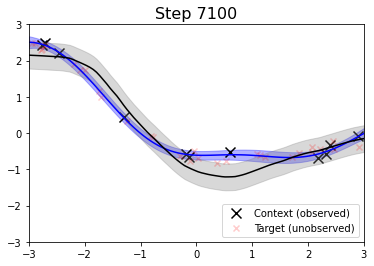

-7.090499401092529, -6.7633514404296875, 0.32714807987213135


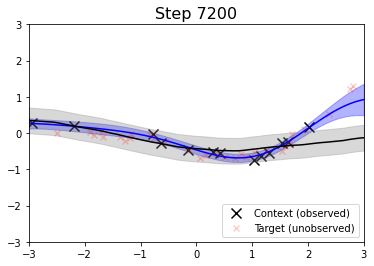

-25.068361282348633, -8.630510330200195, 16.437850952148438


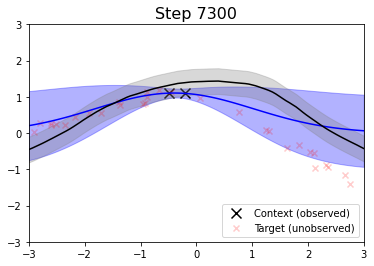

-11.95070743560791, -7.98105001449585, 3.9696576595306396


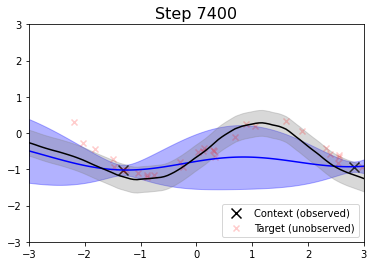

-7.534568786621094, -7.149514198303223, 0.3850545585155487


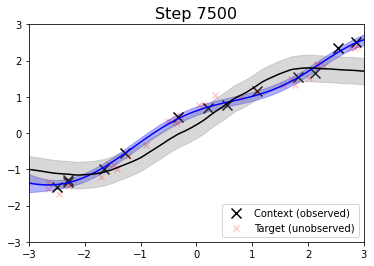

-10.910294532775879, -9.043478012084961, 1.8668164014816284


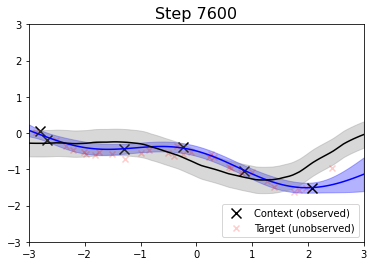

-23.1549072265625, -9.218940734863281, 13.935966491699219


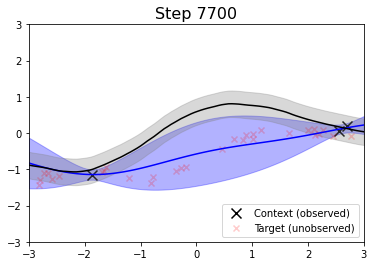

-26.860559463500977, -7.144493103027344, 19.716066360473633


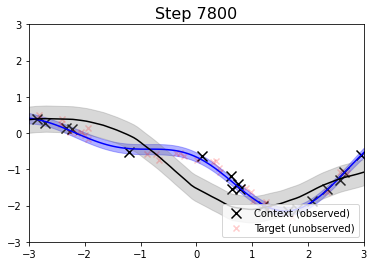

-9.745609283447266, -7.018921852111816, 2.7266876697540283


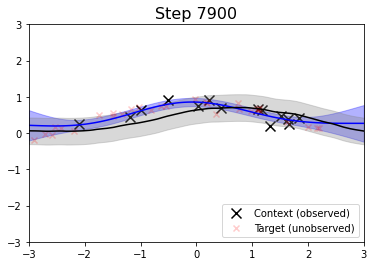

-8.15975570678711, -6.635316848754883, 1.5244386196136475


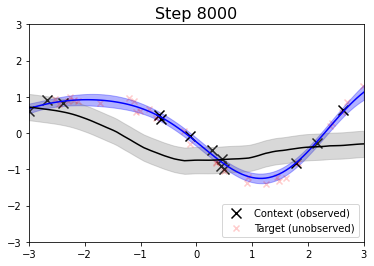

-9.171916961669922, -8.80908203125, 0.36283496022224426


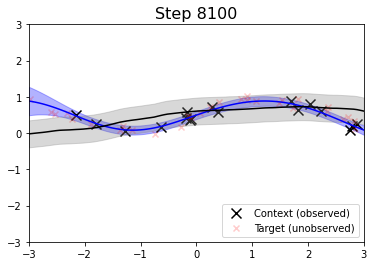

-9.843606948852539, -9.465229988098145, 0.3783773183822632


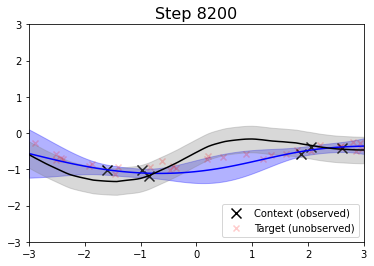

-9.46096420288086, -9.004582405090332, 0.45638182759284973


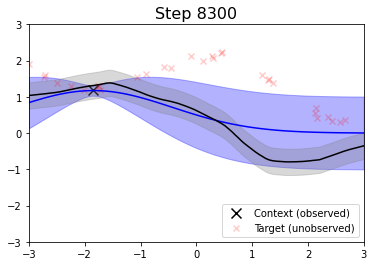

-8.416191101074219, -7.773378372192383, 0.6428127884864807


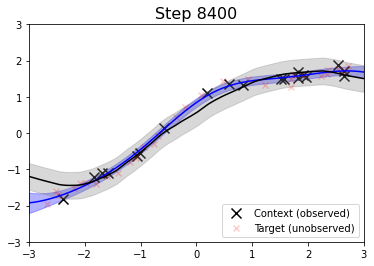

-12.522478103637695, -9.551816940307617, 2.970660924911499


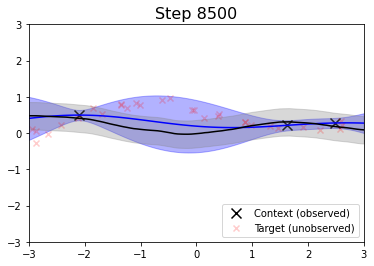

-9.931498527526855, -9.746447563171387, 0.18505136668682098


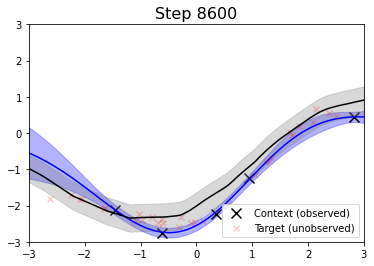

-16.01842498779297, -8.067475318908691, 7.950948715209961


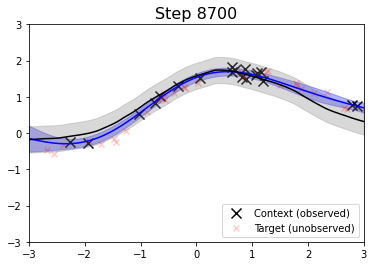

-9.899222373962402, -6.802458763122559, 3.096763849258423


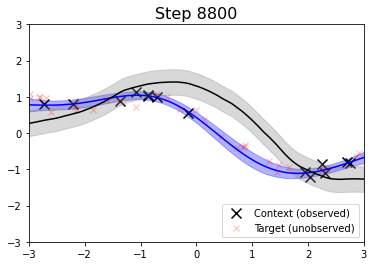

-26.124250411987305, -10.146971702575684, 15.977278709411621


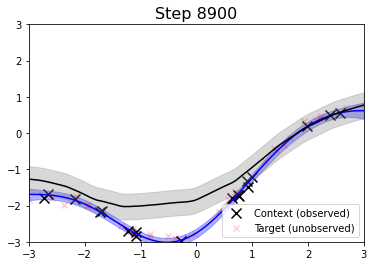

-10.670767784118652, -7.992312908172607, 2.678454875946045


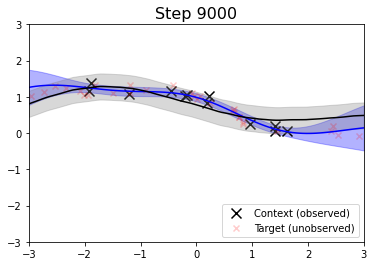

-10.737759590148926, -8.956494331359863, 1.781265377998352


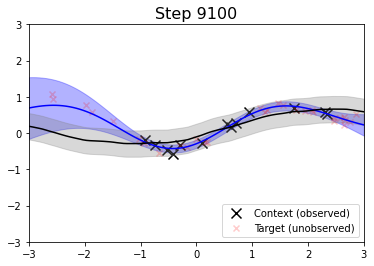

-16.033205032348633, -7.673628330230713, 8.359577178955078


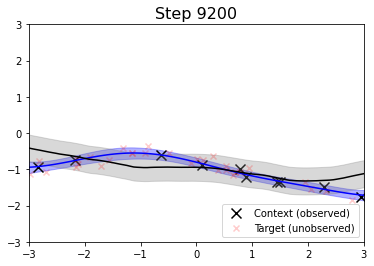

-6.703583240509033, -6.435662746429443, 0.26792046427726746


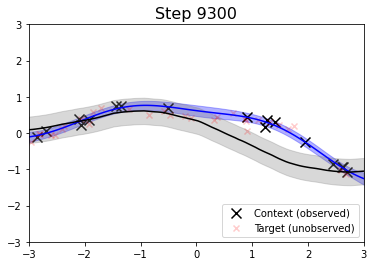

-23.884647369384766, -7.174258232116699, 16.710390090942383


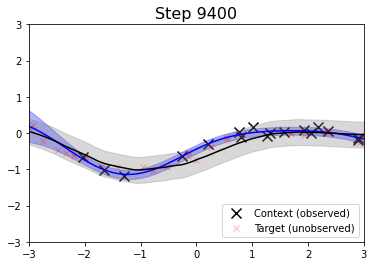

-11.506086349487305, -7.616053104400635, 3.890033483505249


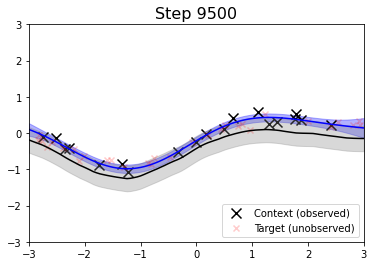

-9.045574188232422, -7.795660018920898, 1.2499136924743652


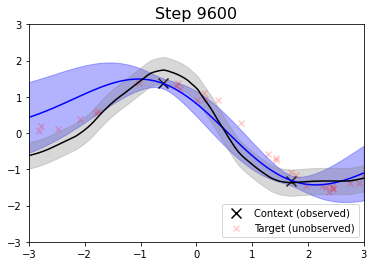

-24.74221420288086, -9.432762145996094, 15.309453010559082


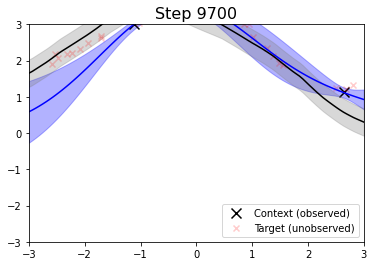

-40.057098388671875, -6.774282455444336, 33.28281784057617


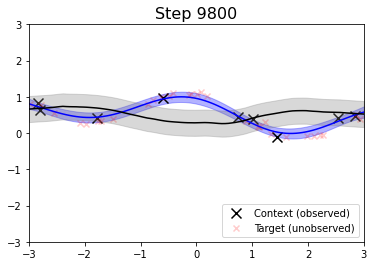

-15.52910041809082, -6.129514217376709, 9.399585723876953


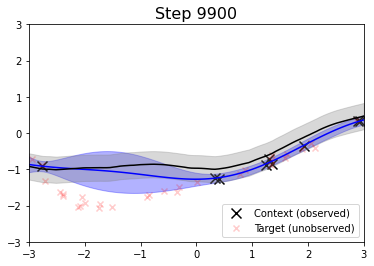

-8.268183708190918, -7.307811737060547, 0.9603715538978577


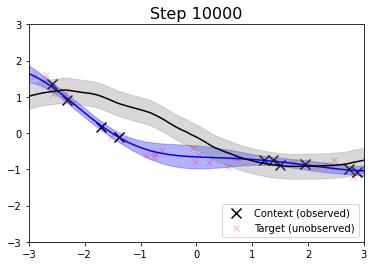

-7.041749000549316, -6.754275798797607, 0.28747323155403137


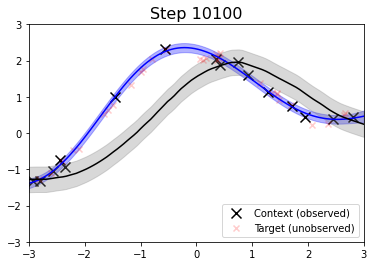

-8.757898330688477, -7.4793829917907715, 1.278515100479126


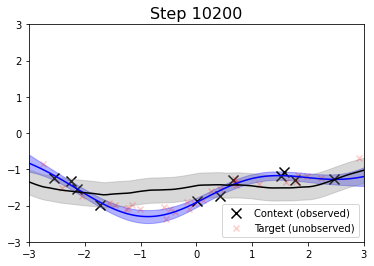

-7.954730033874512, -7.444217205047607, 0.5105128288269043


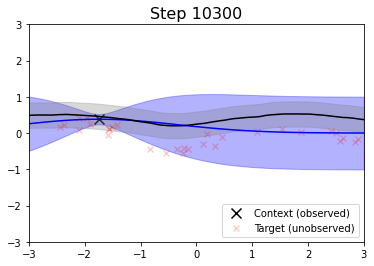

-8.17260456085205, -7.380096435546875, 0.792508065700531


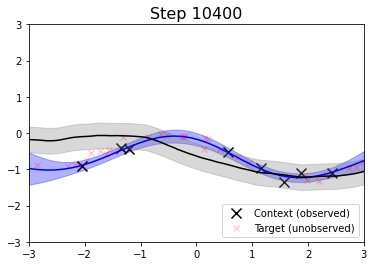

-8.80517864227295, -6.430529594421387, 2.3746488094329834


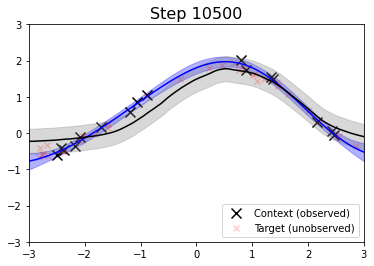

-13.920692443847656, -7.606070518493652, 6.314622402191162


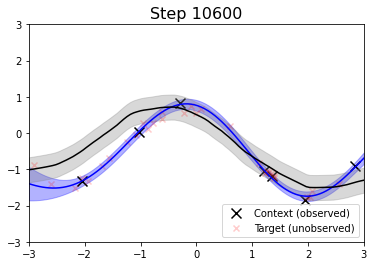

-19.920867919921875, -9.152116775512695, 10.76875114440918


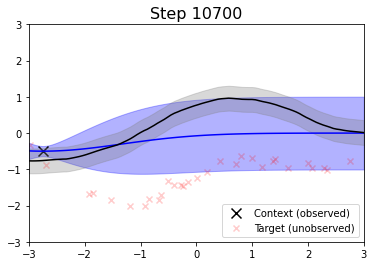

-7.1219706535339355, -6.461523056030273, 0.6604475378990173


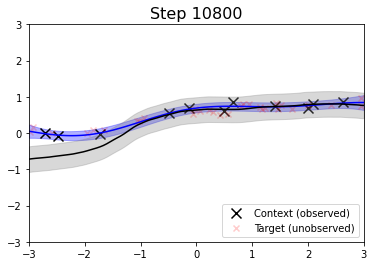

-8.070768356323242, -6.769608020782471, 1.3011603355407715


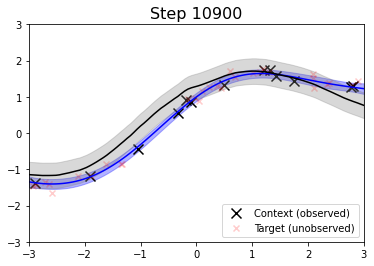

-27.582460403442383, -6.380624771118164, 21.20183563232422


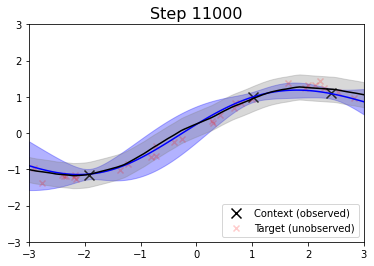

-9.112526893615723, -6.172135353088379, 2.940391778945923


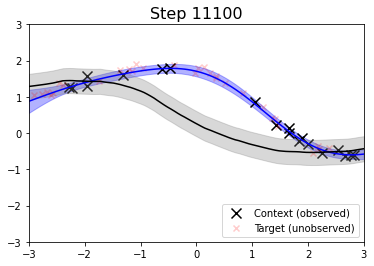

-49.28990173339844, -5.650873184204102, 43.6390266418457


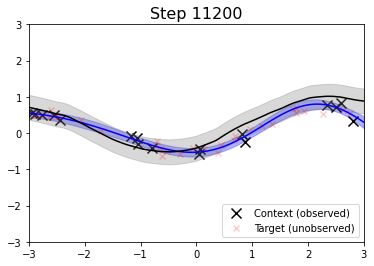

-11.12643051147461, -8.255505561828613, 2.870925188064575


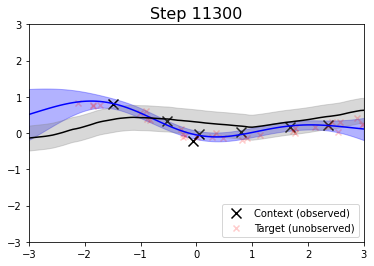

-14.495553970336914, -8.901751518249512, 5.593802452087402


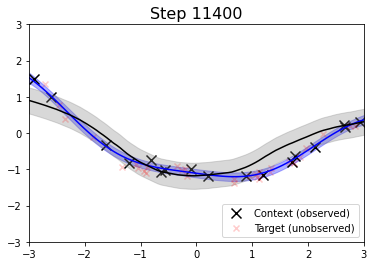

-10.966917991638184, -8.111672401428223, 2.855245590209961


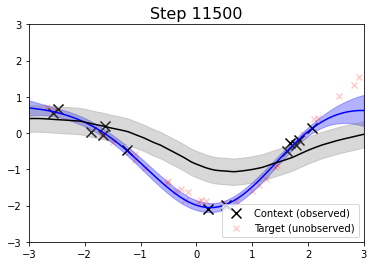

-20.669153213500977, -6.892612457275391, 13.776540756225586


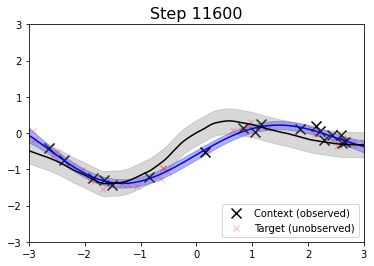

-8.71731185913086, -7.715961933135986, 1.0013494491577148


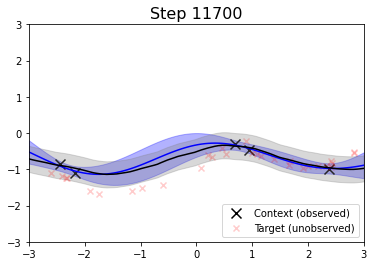

-20.99468421936035, -4.869333267211914, 16.125350952148438


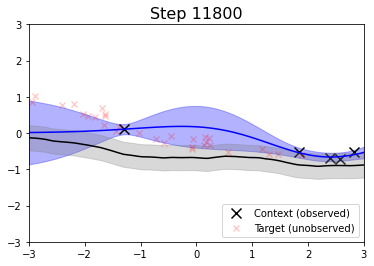

-6.316485404968262, -5.352071762084961, 0.9644137024879456


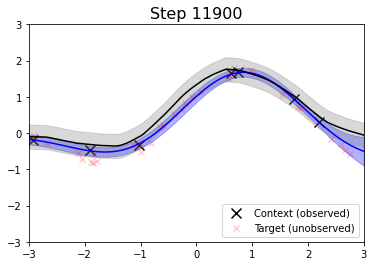

-12.020862579345703, -10.665009498596191, 1.3558526039123535


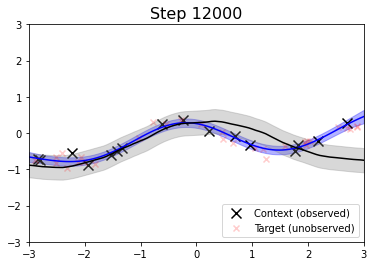

-8.333013534545898, -6.817688941955566, 1.5153242349624634


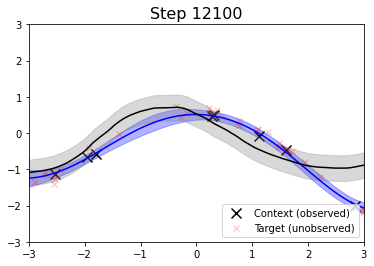

-23.96002197265625, -7.2330827713012695, 16.726940155029297


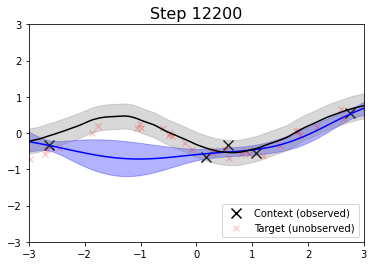

-10.832213401794434, -7.715676307678223, 3.116537094116211


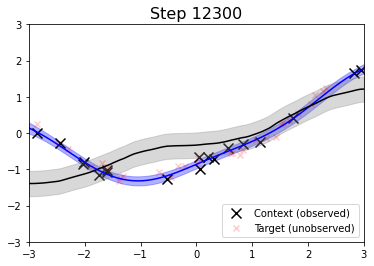

-8.245503425598145, -7.833064079284668, 0.4124397933483124


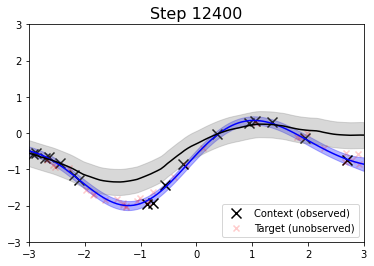

-18.489084243774414, -7.573740005493164, 10.91534423828125


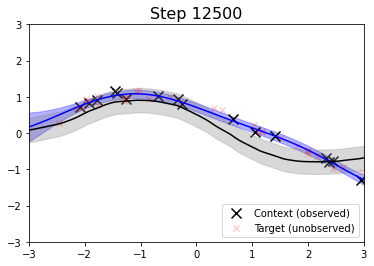

-8.21271800994873, -7.345133304595947, 0.8675850629806519


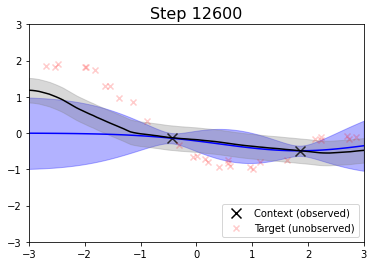

-20.954532623291016, -7.678865909576416, 13.275666236877441


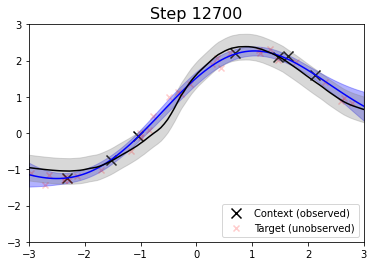

-9.399439811706543, -8.386713027954102, 1.0127267837524414


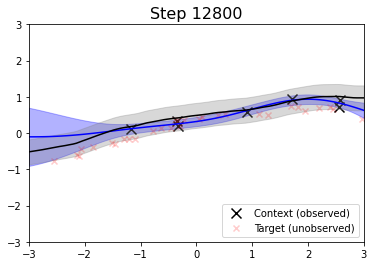

-24.149194717407227, -6.130001544952393, 18.019193649291992


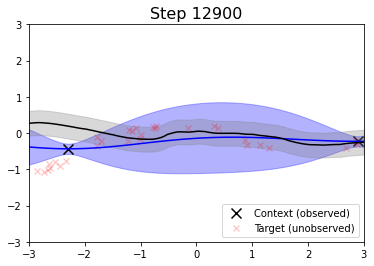

-7.399363040924072, -6.714601039886475, 0.6847618222236633


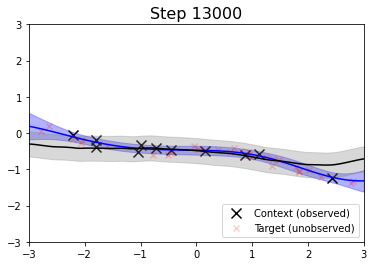

-6.96824312210083, -5.725116729736328, 1.2431262731552124


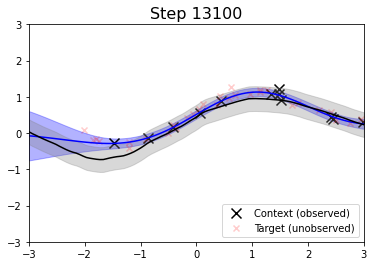

-8.988566398620605, -7.421944618225098, 1.566622018814087


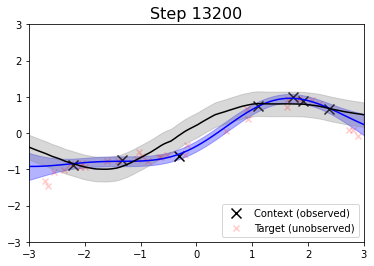

-14.691983222961426, -7.903424263000488, 6.7885589599609375


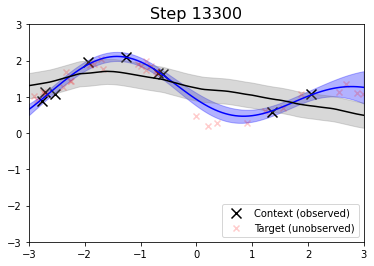

-9.491530418395996, -7.768696308135986, 1.7228339910507202


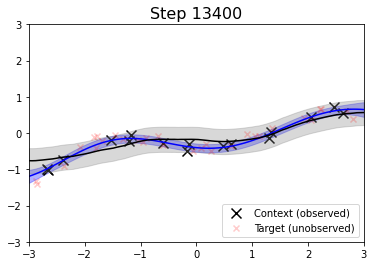

-24.367219924926758, -7.500715732574463, 16.866504669189453


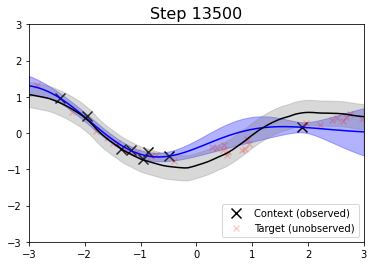

-29.31302833557129, -6.432898998260498, 22.880128860473633


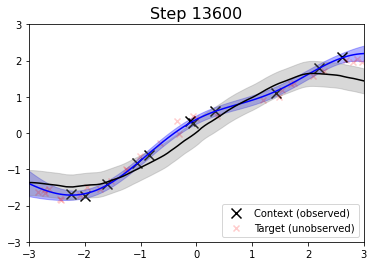

-10.068767547607422, -8.317670822143555, 1.751096487045288


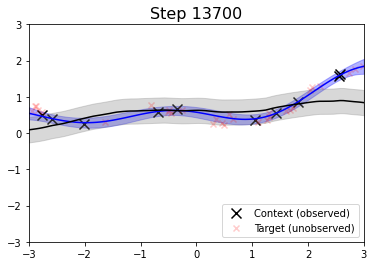

-17.530345916748047, -5.683114051818848, 11.847232818603516


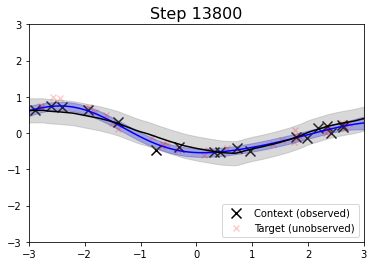

-4.615483283996582, -4.32062292098999, 0.29486027359962463


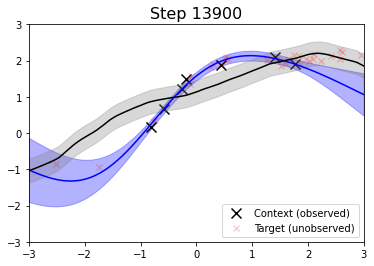

-9.208642959594727, -6.033402442932129, 3.1752407550811768


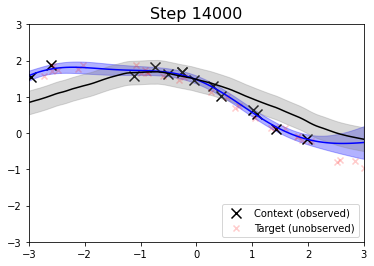

-10.60656452178955, -6.609981536865234, 3.9965832233428955


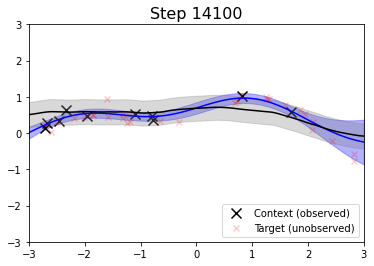

-8.146268844604492, -7.303829193115234, 0.842440128326416


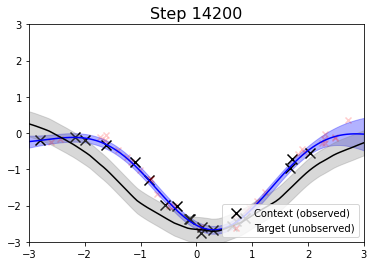

-7.441375732421875, -6.67420768737793, 0.7671682834625244


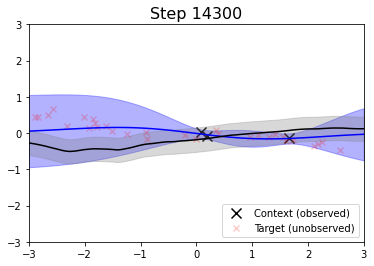

-5.65714693069458, -5.425463676452637, 0.23168306052684784


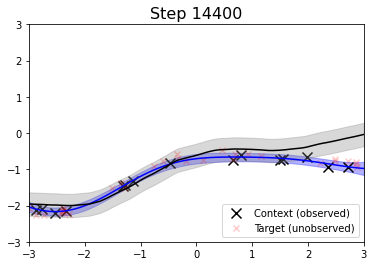

-9.055685997009277, -7.214372158050537, 1.8413139581680298


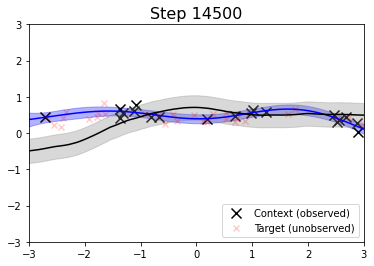

-10.577524185180664, -6.412050724029541, 4.165473461151123


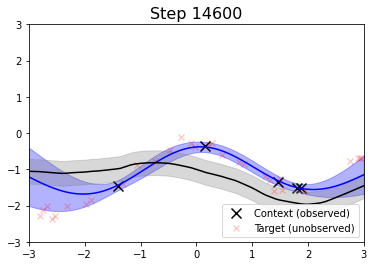

-7.138281345367432, -6.167102813720703, 0.9711785316467285


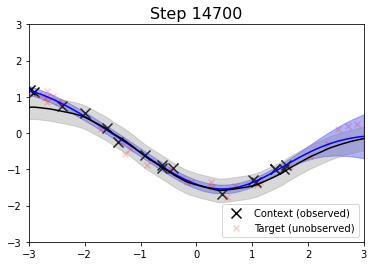

-9.606729507446289, -5.612791538238525, 3.9939379692077637


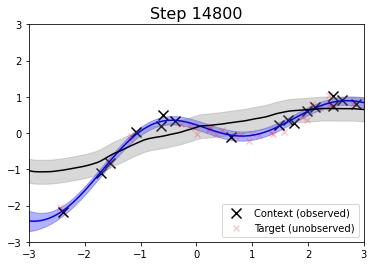

-8.05711555480957, -7.647194862365723, 0.4099208414554596


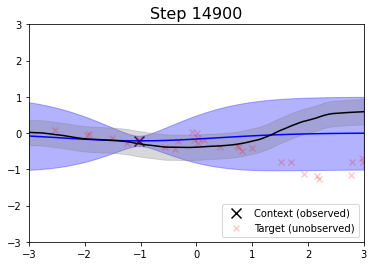

-8.16948127746582, -7.352097034454346, 0.8173839449882507


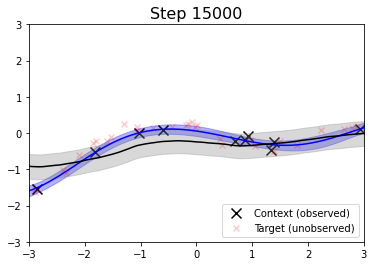

-8.887267112731934, -7.828341484069824, 1.0589256286621094


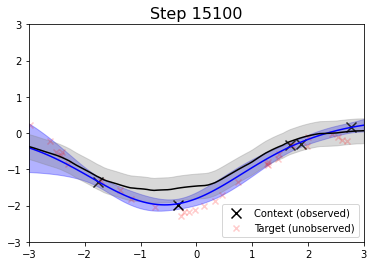

-7.842683792114258, -7.050830841064453, 0.7918529510498047


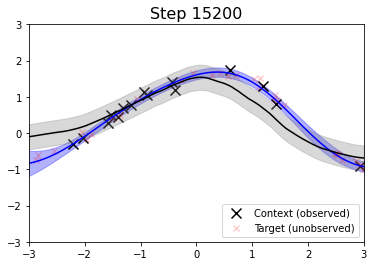

-16.162796020507812, -5.678803443908691, 10.483992576599121


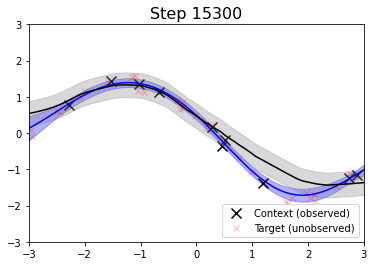

-24.65393829345703, -6.4351372718811035, 18.218801498413086


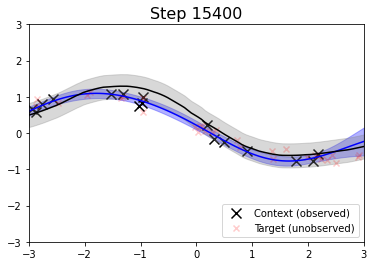

-11.055634498596191, -5.973488807678223, 5.082145690917969


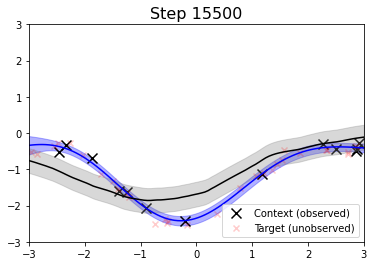

-10.63955307006836, -7.16287899017334, 3.4766745567321777


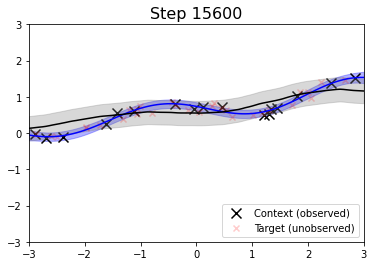

-18.06275749206543, -5.130892276763916, 12.931865692138672


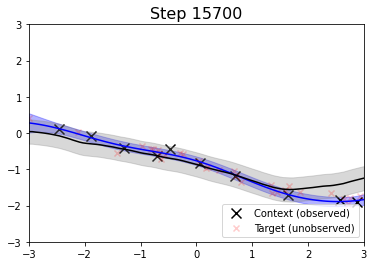

-14.424238204956055, -6.31638765335083, 8.107850074768066


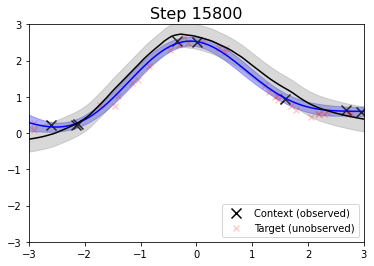

-6.980196475982666, -6.8114447593688965, 0.16875170171260834


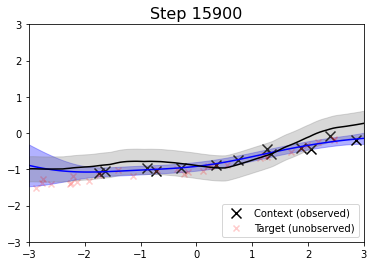

-8.821688652038574, -7.299897193908691, 1.5217915773391724


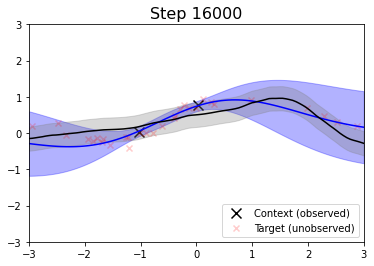

-13.82481575012207, -5.340336799621582, 8.484478950500488


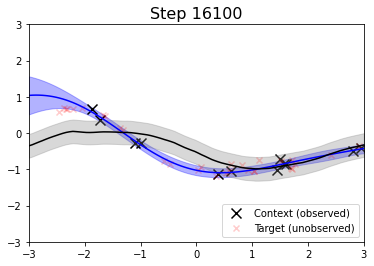

-6.235487461090088, -5.720508098602295, 0.5149795413017273


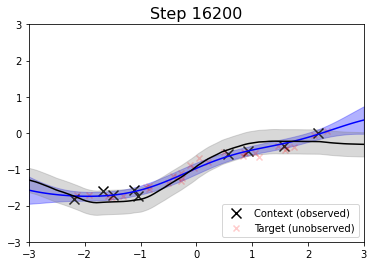

-6.504910469055176, -5.903594493865967, 0.6013160943984985


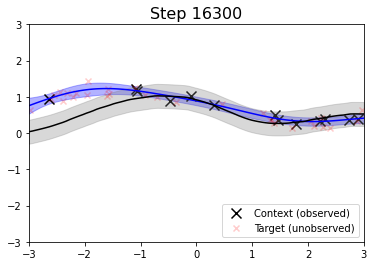

-14.192283630371094, -6.703875541687012, 7.488407611846924


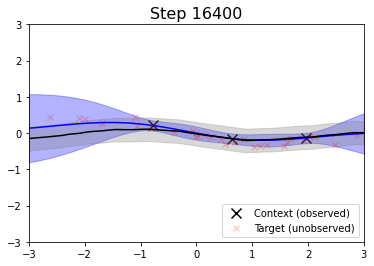

-7.797102451324463, -5.717867851257324, 2.0792346000671387


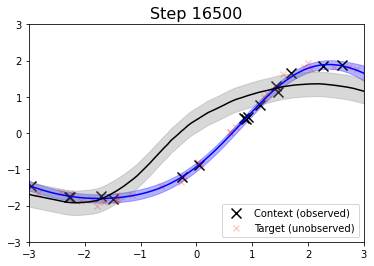

-4.977418899536133, -4.7254838943481445, 0.2519347667694092


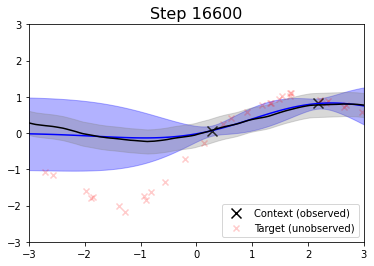

-9.43026351928711, -8.037890434265137, 1.3923730850219727


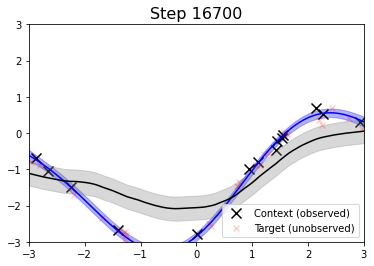

-7.6129655838012695, -4.999552249908447, 2.6134133338928223


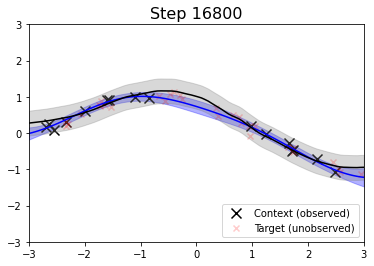

-8.83076286315918, -8.023402214050293, 0.8073607087135315


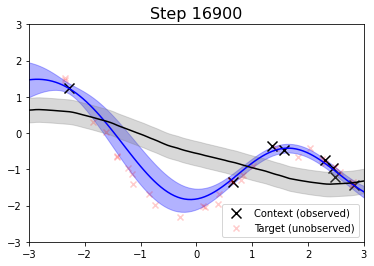

-6.75954008102417, -6.007419586181641, 0.7521204948425293


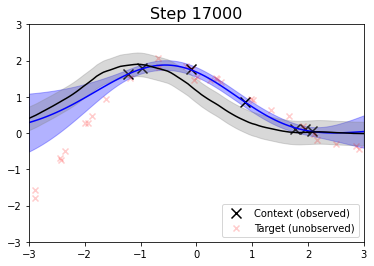

-10.605384826660156, -6.901912212371826, 3.703472852706909


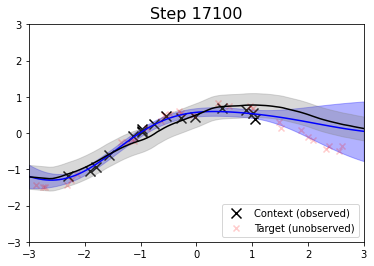

-5.792591571807861, -5.5064849853515625, 0.2861064076423645


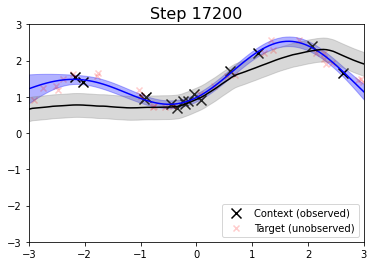

-36.41636657714844, -8.786361694335938, 27.630006790161133


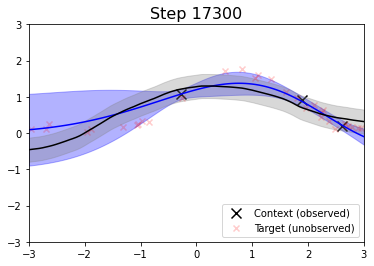

-6.956361770629883, -6.6898016929626465, 0.2665601372718811


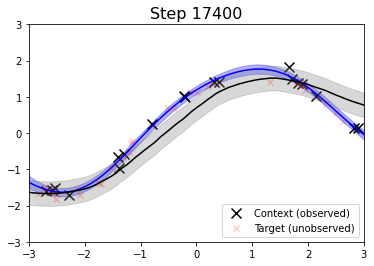

-8.102057456970215, -5.593975067138672, 2.508082389831543


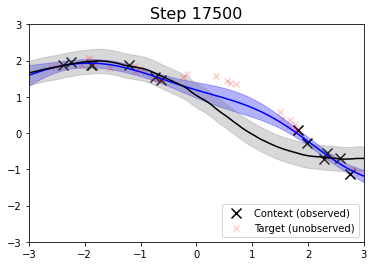

-11.056122779846191, -5.622665882110596, 5.433456897735596


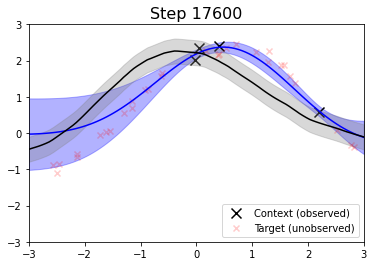

KeyboardInterrupt: 

In [239]:
# Dataset parameters
batch_size = 50
num_train = 20
num_test = 5
scale = 1.
cov_coeff = 1e0
noise_coeff = 1e-1
as_tensor = True
plot_input_range = (-3., 3.)

# Neural Process parameters
num_mc_samples = 10
num_subsamples = 1

# Training parameters and optimizer
num_train_steps = int(1e5)
lr = 1e-3

# Plotting parameters
data_low = -3.
data_high = 3.

# Encoder modules
transformation = FeedforwardNetwork(input_dim=2,
                                    output_dim=256,
                                    nums_hidden=[128, 128],
                                    nonlinearity='ReLU')

stochastic_layer = NormalStochasticLayer(single_noise_param=False,
                                         reparam_func='sigmoid')

encoder = ConcatenationEncoder(transformation,
                               stochastic_layer)

# Decoder modules
transformation = FeedforwardNetwork(input_dim=129,
                                    output_dim=1,
                                    nums_hidden=[128, 128, 128, 128],
                                    nonlinearity='ReLU')

stochastic_layer = NormalStochasticLayer(single_noise_param=True,
                                         reparam_func='softplus')

decoder = RepeatDecoder(transformation,
                        stochastic_layer)


# Neural Process
prior = torch.distributions.Normal

neural_process = NeuralProcess(encoder,
                               decoder,
                               prior)

# Optimizer
optimizer = torch.optim.Adam(neural_process.parameters(), lr=lr)

losses = []

for i in range(num_train_steps):
    
    optimizer.zero_grad()
    
    train_data, test_data = sample_datasets_from_gps(data_low,
                                                     data_high,
                                                     batch_size,
                                                     num_train,
                                                     num_test,
                                                     scale,
                                                     cov_coeff,
                                                     noise_coeff,
                                                     as_tensor)
    
    inputs, outputs = train_data
    
    loss, log_lik, kl_divergence = neural_process.loss(inputs=train_data[0],
                                                       outputs=train_data[1],
                                                       num_mc_samples=num_mc_samples,
                                                       num_subsamples=num_subsamples)
    
    loss.backward()
    optimizer.step()
    
    if i % 1e2 == 0:
        
        num_train_plot = np.random.choice(np.arange(1, num_train))
        
        print(f'{-loss.detach().numpy()}, {log_lik.detach().numpy()}, {kl_divergence.detach().numpy()}')
        
        np_plot_sample_and_predictions(neural_process=neural_process,
                                       low=data_low,
                                       high=data_high,
                                       input_range=plot_input_range,
                                       num_train=num_train_plot,
                                       num_test=30,
                                       scale=scale,
                                       cov_coeff=cov_coeff,
                                       noise_coeff=noise_coeff,
                                       step=i,
                                       plot_test_data=True)
        
        torch.save(neural_process.state_dict(), f'./model_checkpoints/neural-process-chkpt-{i}')

(-3.0, 3.0)

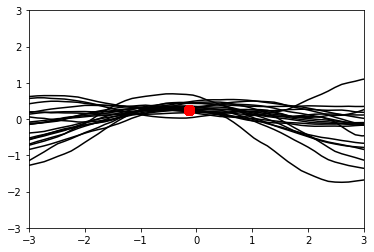

In [243]:
# Dataset parameters
num_train = 1
num_test = 5
scale = 1.
cov_coeff = 1e0
noise_coeff = 1e-1
as_tensor = True
input_range = (-6., 6.)

train_data, test_data = sample_datasets_from_gps(low=-3.,
                                                 high=3.,
                                                 batch_size=1,
                                                 num_train=num_train,
                                                 num_test=num_test,
                                                 scale=scale,
                                                 cov_coeff=cov_coeff,
                                                 noise_coeff=noise_coeff,
                                                 as_tensor=True)

context_inputs, context_outputs = train_data
target_inputs = torch.linspace(input_range[0],
                               input_range[1],
                               100)[None, :, None]

for i in range(20):
    
    pred_mean, pred_stddev = neural_process.forward(context_inputs,
                                                    context_outputs,
                                                    target_inputs)
    
    pred_mean = pred_mean[0, :].detach().numpy()
    pred_stddev = pred_stddev[0, :].detach().numpy()
    
    plt.plot(target_inputs[0, :, 0],
             pred_mean,
             color='black',
             zorder=1)
    
    plt.scatter(train_data[0],
                train_data[1],
                color='red',
                s=100,
                zorder=2)
    
plt.xlim([-3., 3.])
plt.ylim([-3., 3.])

# Plotting epistemic and aleatoric uncertainties

(10, 100) (10, 100)
(100,)


(-3.0, 3.0)

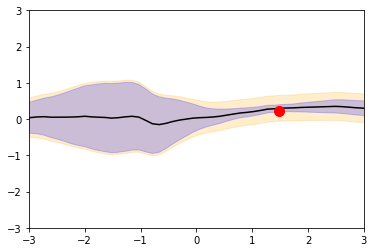

In [255]:
# Dataset parameters
num_train = 1
num_test = 5
scale = 1.
cov_coeff = 1e0
noise_coeff = 1e-1
as_tensor = True
input_range = (-6., 6.)

train_data, test_data = sample_datasets_from_gps(low=-3.,
                                                 high=3.,
                                                 batch_size=1,
                                                 num_train=num_train,
                                                 num_test=num_test,
                                                 scale=scale,
                                                 cov_coeff=cov_coeff,
                                                 noise_coeff=noise_coeff,
                                                 as_tensor=True)

context_inputs, context_outputs = train_data
target_inputs = torch.linspace(input_range[0],
                               input_range[1],
                               100)[None, :, None]

pred_means = []
pred_vars = []

for i in range(10):
    
    pred_mean, pred_stddev = neural_process.forward(context_inputs,
                                                    context_outputs,
                                                    target_inputs)
    
    pred_mean = pred_mean[0, :].detach().numpy()
    pred_var = pred_stddev[0, :].detach().numpy() ** 2
    
    pred_means.append(pred_mean)
    pred_vars.append(pred_var)
    
pred_means = np.stack(pred_means, axis=0)
pred_vars = np.stack(pred_vars, axis=0)
print(pred_means.shape, pred_vars.shape)

mean = np.mean(pred_means, axis=0)

var_aleatoric = np.mean(pred_vars, axis=0)
var_epistemic = np.var(pred_means, axis=0)
var_total = var_epistemic + var_aleatoric
print(var_total.shape)
    
plt.plot(target_inputs[0, :, 0], pred_mean, color='black', zorder=1)

plt.fill_between(target_inputs[0, :, 0], 
                 pred_mean - var_total ** 0.5, 
                 pred_mean + var_total ** 0.5, 
                 color='orange',
                 alpha=0.2,
                 zorder=1)

plt.fill_between(target_inputs[0, :, 0],
                 pred_mean - var_epistemic ** 0.5,
                 pred_mean + var_epistemic ** 0.5,
                 color='blue',
                 alpha=0.2,
                 zorder=1)

# plt.fill_between(target_inputs[0, :, 0], 
#                  pred_mean - pred_stddev, 
#                  pred_mean + pred_stddev, 
#                  color='gray',
#                  alpha=0.2,
#                  zorder=1)
# plt.scatter(train_data[0], train_data[1], color='red', s=100, zorder=2)
plt.scatter(train_data[0], train_data[1], color='red', s=100, zorder=2)

plt.xlim([-3., 3.])
plt.ylim([-3., 3.])